# Evaporation tutorial
## Tutorial 2: Implicit evaporation

Make sure that hoomd-blue and azplugins are installed correctly. For more details see Tutorial 0. 
A corresponding tutorial with explicit solvent can be found in the same folder.

In this tutorial, we will set up a evaporation simulation of solutes with an implicit solvent. For simplicity, we'll use spherical colloids (green, red) which are purely repulsive. The simulation box will be periodic in $x$ and $y$, and have a wall(black) in $z$ direction, the evaporation direction. Because there is no solvent to delete, evaporation is realized by a moving purely repulsive harmonic interface (dashed blue line) pushing down particles during the simulation. 

![system_sketch](system_sketch2.png)

### System setup
First, we will initialize the particles in the box with a small helper function ``init_mixture`` which takes the ``system, snapshot`` and some information about the system, such as smaller colloids $\sigma_B=$ `s_B` and bigger colloids $\sigma_A=$ `s_A` diameters, respective densities ($\rho_B=$ `rho_B` and $\rho_A=$ `rho_A`), desired liquid film height `height`, and temperature `kT`. It returns a filled in snapshot for hoomd to initialize. Depending on the systen, writing a class to initialize the system can be helpful, too. For this tutorial, we just simply put both colloids on a simple cubic lattice such that they don't overlap (checked with ``cdist``). Then, we assing random velocities according to the expected Boltzmann distribution and we also assume that the particles are buoyancy matched, meaning their mass should scale with volume. The bigger colloid is particle type `A` or typeid `0` and the smaller one is type `B`, typeid `1`.

```Python
import numpy as np
import sys
import hoomd
from hoomd import md
from hoomd import data
from hoomd import azplugins
from scipy.spatial.distance import cdist

def init_mixture(system,snapshot,rho_B,rho_A,height,s_B,s_A,kT):
    Lx = system.box.Lx
    Ly = system.box.Ly
    Lz = system.box.Lz
    N_B = int(rho_B*Lx*Ly*height)
    N_A = int(rho_A*Lx*Ly*height)
    s_AB = 0.5*(s_B+s_A)

    snapshot.particles.resize(N_A+N_B)

    lx = np.arange(-Lx/2.+s_A/2.,+Lx/2.,s_A)
    ly = np.arange(-Ly/2.+s_A/2.,+Ly/2.,s_A)
    lz = np.arange(-Lz/2.+s_AB,-Lz/2.+s_AB+height,s_A)
    positions_Square_lattice_A = np.asarray(np.meshgrid(lx, ly, lz)).reshape(3,-1).transpose()
    np.random.shuffle(positions_Square_lattice_A)
    pos_A = positions_Square_lattice_A[:N_A]

    lx = np.arange(-Lx/2.+s_A/2.,+Lx/2.,s_B)
    ly = np.arange(-Ly/2.+s_A/2.,+Ly/2.,s_B)
    lz = np.arange(-Lz/2.+s_AB,-Lz/2.+s_AB+height,s_B)
    positions_Square_lattice_B = np.asarray(np.meshgrid(lx, ly, lz)).reshape(3,-1).transpose()

    dist = cdist(positions_Square_lattice_B,pos_A)
    eps=0.5
    cut = np.any(dist<0.5*(s_A+s_B),axis=1)
    positions_Square_lattice_B= positions_Square_lattice_B[~cut]
    np.random.shuffle(positions_Square_lattice_B)
    pos_B = positions_Square_lattice_B[:N_B]
    pos = np.vstack((pos_A,pos_B))
    mass_ratio = s_A**3/s_B**3
    snapshot.particles.typeid[:]= np.hstack((np.zeros(N_A),np.ones(N_B)))
    snapshot.particles.mass[:]= np.hstack((np.ones(N_A)*mass_ratio,np.ones(N_B)))
    snapshot.particles.position[:] = pos
    snapshot.particles.velocity[:] = np.random.normal(0, np.sqrt(kT), (N_A+N_B,3))
    snapshot.particles.velocity[:] -= np.average(snapshot.particles.velocity,axis=0)

    return snapshot

L = 25
Lz = 52
height = 50
kT = 1.0

rho_A = 0.005
s_A  = 4.0
rho_B = 0.1
s_B  = 1.0

hoomd.context.initialize()
hoomd.context.SimulationContext()

snapshot = hoomd.data.make_snapshot(N=0,box=data.boxdim(Lx=L,Ly=L,Lz=Lz),particle_types=['A','B'])
system = hoomd.init.read_snapshot(snapshot)

snapshot_init = init_mixture(system,snapshot,rho_B,rho_A,height,s_B,s_A,kT)
system.restore_snapshot(snapshot_init)
```

Now, we need to define all interactions in the system. Colloids interact with a purely repulsive WCA potential, and the wall is a Lennard-Jones 9-3 wall, attractive at the bottom and repulsive at the top (cut at $(2/5)^{1/6.}\sigma_i$).

```Python
s_AB = 0.5*(s_B+s_A)
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(nlist=nl,r_cut =3.0*s_A,name='n')
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=s_A, r_cut=2**(1/6.)*s_A)
lj.pair_coeff.set('B', 'A', epsilon=1.0, sigma=s_AB, r_cut=2**(1/6.)*s_AB)
lj.pair_coeff.set('B', 'B', epsilon=1.0, sigma=s_B, r_cut=2**(1/6.)*s_B)

lower_wall=hoomd.md.wall.group()
lower_wall.add_plane((0,0,-Lz/2.), (0,0,1))
lj_wall_lo=azplugins.wall.lj93(lower_wall, r_cut=3.0*s_AB,name='wall')
lj_wall_lo.force_coeff.set(['A','B'], epsilon=2.5, sigma=s_AB, r_cut=3.0*s_AB)

upper_wall=hoomd.md.wall.group()
upper_wall.add_plane((0,0,Lz/2.), (0,0,-1))
lj_wall_up=azplugins.wall.lj93(upper_wall, r_cut=s_AB*(2/5.)**(1/6.))
lj_wall_up.force_coeff.set(['A','B'], epsilon=2.5, sigma=s_AB, r_cut=(2/5.)**(1/6.)*s_AB)

```


### Equilibration

First we need to equilibrate the liquid initial lattice configuration. Because there is no explicit solvent, it will fill the entire box at first, so your initial flim height is the distance between the walls. In practice, this should be longer, depending on your system. 

```Python
all = hoomd.group.all()

hoomd.md.integrate.mode_standard(dt = 0.005)
langevin = hoomd.md.integrate.langevin(group=all, kT=kT, seed=457)
hoomd.run(1e4)

```

### Evaporation

Now, we need to set up the evaporation. 

```Python
interf = hoomd.variant.linear_interp([[0,+Lz/2],[5e5,-Lz/2+5]],zero=0)
evap = azplugins.evaporate.implicit(interface=interf)
evap.force_coeff.set('B', k=50.0, offset=0.0, g=50.0*0.5, cutoff=0.5)
evap.force_coeff.set('A', k=50.0*(s_A)**2, offset=0.0, g=50.0*(s_A)**3/2., cutoff=1.0)
langevin.set_gamma('A', gamma=2.5*s_A/s_B)
langevin.set_gamma('B', gamma=2.5)
```

### Evaporation parameters


```Python

class measure_evaporation:
    def __init__(self, system, binsize):
        self.system   = system
        self.binsize  = binsize
        self.num_bins = np.round(self.system.box.Lz/self.binsize).astype(int)
        self.types    = np.asarray(self.system.particles.types)
        self.H_dens   = np.zeros((len(self.types),self.num_bins))
        self.counter  = 0
        self.range    = [-self.system.box.Lz/2.,self.system.box.Lz/2.]
        self.bin_vol  = float(self.system.box.Lz)/float(self.num_bins)*self.system.box.Lx*self.system.box.Ly
        self.outfile = open('tutorial_evaporation_explicit.txt', 'w+')
        self.outfile.write("# timestep N_sol\n")

    def __call__(self, timestep):
        hoomd.util.quiet_status()
        snap = self.system.take_snapshot()
        hoomd.util.unquiet_status()
        pos = snap.particles.position
        # pick z coordinates
        pos_z = pos[:,2]
        for t in self.types:
            i = np.argwhere(self.types==t)[0][0]
            H_dens, edges = np.histogram(pos_z[np.where(snap.particles.typeid==i)],bins = self.num_bins,range=self.range)
            self.H_dens[i]  = H_dens
        centers  =  (edges[:-1] + edges[1:])/2
        temp = np.zeros(len(centers))
        # temperature histogram
        for i,c in enumerate(centers):
            slab_vel = snap.particles.velocity[np.abs(pos[:,2]-c)<self.binsize]
            l = len(slab_vel)
            if l>0:
                v_squared = slab_vel[:,0]**2 + slab_vel[:,1]**2 + slab_vel[:,2]**2
                T = 1/(3*l)*np.sum(v_squared)
            else:
                T=0
            temp[i]=T

                # normalize density
        to_save_H = self.H_dens/self.bin_vol

        res = np.vstack((np.asarray(centers),to_save_H,temp)).T
        np.savetxt('tutorial_evaporation_implicit_dens_%05d.hist'%hoomd.get_step(),res, header="z, density %s temp"%self.types)

        self.counter += 1
        
hoomd.dump.gsd(filename="tutorial_01_implicit_evaporation_trajectory.gsd",
               overwrite=True, period=5e3, group=all)

hoomd.analyze.log('out.log',period=1,quantities=['pair_lj_energy_n'],overwrite=True)
o = measure_evaporation(system, binsize=1.0)
analyze =  hoomd.analyze.callback(o, period=5e3)

```


The only thing left to do is run the simulation:
```Python
hoomd.run(5e5)

```


## Analyzing the results

First, have a look at the generated trajectory. Use either [vmd](https://www.ks.uiuc.edu/Research/vmd/) with the [gsd plugin](https://github.com/mphoward/gsd-vmd), [ovito](https://www.ovito.org/), or your favorite configuration viewer. 

We can also have a look at temperature and density histograms we wrote out during the simulation.

OSError: tutorial_evaporation_implicit_dens_100000.hist not found.

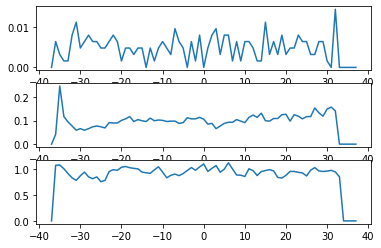

In [2]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3)
    
for i in [10000,100000,200000,270000]:
    # reading the recorded density profile A S T Z 
    density_profile = np.genfromtxt('tutorial_evaporation_implicit_dens_%d.hist'%(i), skip_header=True)
   
    ax[0].plot(density_profile[:,0], density_profile[:,1],label=i)
    ax[1].plot(density_profile[:,0], density_profile[:,2])
    ax[2].plot(density_profile[:,0], density_profile[:,3])

ax[0].legend()
ax[0].set_xlabel('$z$')
ax[0].set_ylabel('$density_{solute}$')
ax[1].set_xlabel('$z$')
ax[1].set_ylabel('$density_{solvent}$')
ax[2].set_xlabel('$z$')
ax[2].set_ylabel('$T$')

plt.show()

The histograms are fairly noisy and you should repeat the same simulation with different seeds and then average them for better statistics. The interface speed is determined by the values in the ``hoomd.variant.linear_interp`` and the diffusion constants are set in the thermostat, so the Peclet number can be computed simply by $Pe_i = v H_\text{init}/D_i$.

### Further reading:

- Stratification Dynamics in Drying Colloidal Mixtures https://pubs.acs.org/doi/full/10.1021/acs.langmuir.7b00543

- Stratification in Drying Polymer–Polymer and Colloid–Polymer Mixtures https://pubs.acs.org/doi/full/10.1021/acs.langmuir.7b02074

